# Home Cage Dopamine Analysis

In [1]:
import os
import sys

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PROJECT_ROOT)

from trial_class import *
from experiment_class import Experiment

from hc_extension import *
from Hab_Dishab.hd_extension import get_trial_dataframes, create_metadata_dataframe, create_da_metrics_dataframe, plot_peak_for_subsequent_investigations_custom

In [2]:
# experiment_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined\Home_Cage\nac"
# csv_base_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined\Home_Cage\nac_csvs"
# brain_region = '#15616F'

# NAc: #15616F
# mPFC: #FFAF00

experiment_path = r"/Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Home_Cage/all/mpfc"
csv_base_path = r"/Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Home_Cage/all_csvs/mpfc_csvs"
brain_region = '#FFAF00'

In [3]:
# groups csv + experiment data into one variable
experiment = Experiment(experiment_path, csv_base_path)

# batch process the data, removing the specified time segments for subjects
experiment.default_batch_process()

Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Home_Cage/all/mpfc/p6-240823-105552/Notes.txt
read from t=0s to t=1807.06s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Home_Cage/all/mpfc/p2-240508-101128/Notes.txt
read from t=0s to t=1820.76s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Home_Cage/all/mpfc/pp4-250121-065035/Notes.txt
read from t=0s to t=1876.76s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Home_Cage/all/mpfc/p7-240824-053845/Notes.txt
read from t=0s to t=1790.87s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Home_Cage/all/mpfc/pp5-250121-110144/Notes.txt
read from t=0s to t=1895.67s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Home_Cage/all/mpfc/pp3-

In [4]:
bout_definitions = [
    {'prefix': 'Short_Term', 'introduced': 'Short_Term_Introduced', 'removed': 'Short_Term_Removed'},
    {'prefix': 'Long_Term', 'introduced': 'Long_Term_Introduced', 'removed': 'Long_Term_Removed'},
    {'prefix': 'Novel', 'introduced': 'Novel_Introduced', 'removed': 'Novel_Removed'}
]

experiment.group_extract_manual_annotations(bout_definitions, first_only=True)

Processing behaviors for p6-240823-105552...
Processing behaviors for p2-240508-101128...
Processing behaviors for pp4-250121-065035...
Processing behaviors for p7-240824-053845...
Processing behaviors for pp5-250121-110144...
Processing behaviors for pp3-250121-055222...
Processing behaviors for pp1-250120-094415...
Processing behaviors for pp6-250121-114116...
Processing behaviors for p1-240508-084607...
Processing behaviors for pp7-250121-134131...
Processing behaviors for pp8-250121-142227...
Processing behaviors for p5-240823-093250...
Processing behaviors for p3-240509-070801...
Processing behaviors for p8-240824-070451...
Processing behaviors for pp2-250121-123301...


### Peak standard z-score

In [5]:
# total_avg_bout_duration = metadata_df["Average Bout Duration"].mean()
# print(f"Total Average Bout Duration: {total_avg_bout_duration:.4f}")
# Proceed with DA metric computation after all files are processed
experiment.compute_all_da_metrics(use_max_length=False,
                                  max_bout_duration=5, #otal_avg_bout_duration
                                  use_adaptive=False, 
                                  allow_bout_extension=False,
                                  mode='standard')

Computing DA metrics for p6-240823-105552 ...
Computing DA metrics for p2-240508-101128 ...
Computing DA metrics for pp4-250121-065035 ...
Computing DA metrics for p7-240824-053845 ...
Computing DA metrics for pp5-250121-110144 ...
Computing DA metrics for pp3-250121-055222 ...
Computing DA metrics for pp1-250120-094415 ...
Computing DA metrics for pp6-250121-114116 ...
Computing DA metrics for p1-240508-084607 ...
Computing DA metrics for pp7-250121-134131 ...
Computing DA metrics for pp8-250121-142227 ...
Computing DA metrics for p5-240823-093250 ...
Computing DA metrics for p3-240509-070801 ...
Computing DA metrics for p8-240824-070451 ...
Computing DA metrics for pp2-250121-123301 ...


In [6]:
exp_da_dict = get_trial_dataframes(experiment)

In [7]:
desired_bouts = ['Short_Term-1', 'Novel-1', 'Short_Term-2', 'Long_Term-1']
da_metadata_df = create_da_metrics_dataframe(exp_da_dict, behavior="Investigation", desired_bouts=desired_bouts)

In [8]:
new_da_df = da_metadata_df.copy() 

# Desired bout order
desired_bout_order = ["Short_Term-1", "Novel-1", "Short_Term-2", "Long_Term-1"]
clean_labels = ["Acq-ST", "Novel", "Short Term", "Long Term"]
xtick_colors = ["teal", "blue", "purple", "orange"]

# Map the bout column to a categorical with desired order
df = new_da_df[new_da_df["Bout"].isin(desired_bout_order)].copy()
df["Bout"] = pd.Categorical(df["Bout"], categories=desired_bout_order, ordered=True)

In [9]:
def dopamine(precomputed_df, 
             metric_name="Mean Z-score", 
             title="Combined DA Metrics", 
             ylabel="DA Metric", 
             xlabel="Bout", 
             custom_xtick_labels=None, 
             custom_xtick_colors=None, 
             ylim=None, 
             bar_color="#00B7D7", 
             yticks_increment=None, 
             figsize=(14,8), 
             pad_inches=0.1,
             save=False,
             save_name=None):
    """
    Plots DA metrics across specific bouts using a provided DataFrame.
    Prints paired t-test results comparing the first bout with others.
    """
    from scipy.stats import ttest_rel
    import numpy as np
    import matplotlib.pyplot as plt

    def perform_t_tests(pivot_df):
        results = {}
        bout_names = pivot_df.columns.tolist()
        for i in range(1, len(bout_names)):
            bout1, bout2 = bout_names[0], bout_names[i]
            paired_df = pivot_df[[bout1, bout2]].dropna()
            if len(paired_df) > 1:
                t_stat, p_value = ttest_rel(paired_df[bout1], paired_df[bout2])
                results[f"{bout1} vs {bout2}"] = {"t_stat": t_stat, "p_value": p_value}
        return results

    df = precomputed_df.copy()

    try:
        pivot_df = df.pivot(index="Subject", columns="Bout", values=metric_name)
    except Exception as e:
        print("Error pivoting data:", e)
        return

    overall_stats = df.groupby("Bout")[metric_name].agg(['mean', 'sem']).reset_index()
    t_test_results = perform_t_tests(pivot_df)

    # --- Plotting ---
    fig, ax = plt.subplots(figsize=figsize)
    bar_positions = np.arange(len(overall_stats))

    ax.bar(bar_positions, overall_stats["mean"], yerr=overall_stats["sem"],
           capsize=6, color=bar_color, edgecolor='black', linewidth=5, width=0.6,
           error_kw=dict(elinewidth=3, capthick=3, zorder=5))

    # Individual subject lines
    for subject_id in pivot_df.index:
        ax.plot(bar_positions, pivot_df.loc[subject_id], linestyle='-', color='gray', 
                alpha=0.5, linewidth=3, marker='o', markerfacecolor='none', 
                markeredgecolor='gray', markeredgewidth=3, markersize=10)

    # Labels
    ax.set_ylabel(ylabel, fontsize=35, labelpad=12)
    ax.set_xlabel(xlabel, fontsize=35, labelpad=12)
    ax.set_title(title, fontsize=28)

    ax.set_xticks(bar_positions)
    xtick_labels = custom_xtick_labels if custom_xtick_labels else overall_stats["Bout"].tolist()
    ax.set_xticklabels(xtick_labels, fontsize=35)
    if custom_xtick_colors:
        for tick, color in zip(ax.get_xticklabels(), custom_xtick_colors):
            tick.set_color(color)

    ax.tick_params(axis='y', labelsize=35)
    ax.tick_params(axis='x', labelsize=35)

    if ylim:
        ax.set_ylim(ylim)
    else:
        all_vals = np.concatenate([pivot_df.values.flatten(), overall_stats["mean"].values])
        ax.set_ylim(0, np.nanmax(all_vals) * 1.2)

    if yticks_increment:
        y_min, y_max = ax.get_ylim()
        ax.set_yticks(np.arange(np.floor(y_min), np.ceil(y_max) + yticks_increment, yticks_increment))

    ax.axhline(y=0, color='black', linestyle='--', linewidth=2)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)

    plt.tight_layout()
    if save:
        if save_name is None:
            raise ValueError("save_name must be provided if save is True.")
        plt.savefig(save_name, transparent=True, bbox_inches='tight', pad_inches=pad_inches)
    plt.show()

    # --- Print T-test Results ---
    if t_test_results:
        print("\nPaired t-test results (first bout vs others):")
        for comp, stats in t_test_results.items():
            p = stats["p_value"]
            stars = "ns"
            if p < 0.001:
                stars = "***"
            elif p < 0.01:
                stars = "**"
            elif p < 0.05:
                stars = "*"
            print(f"{comp}: p = {p:.4f} ({stars})")


/var/folders/tj/nfn3dynx2n19r7566d88xmsc0000gn/T/ipykernel_70560/1471257188.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  overall_stats = df.groupby("Bout")[metric_name].agg(['mean', 'sem']).reset_index()


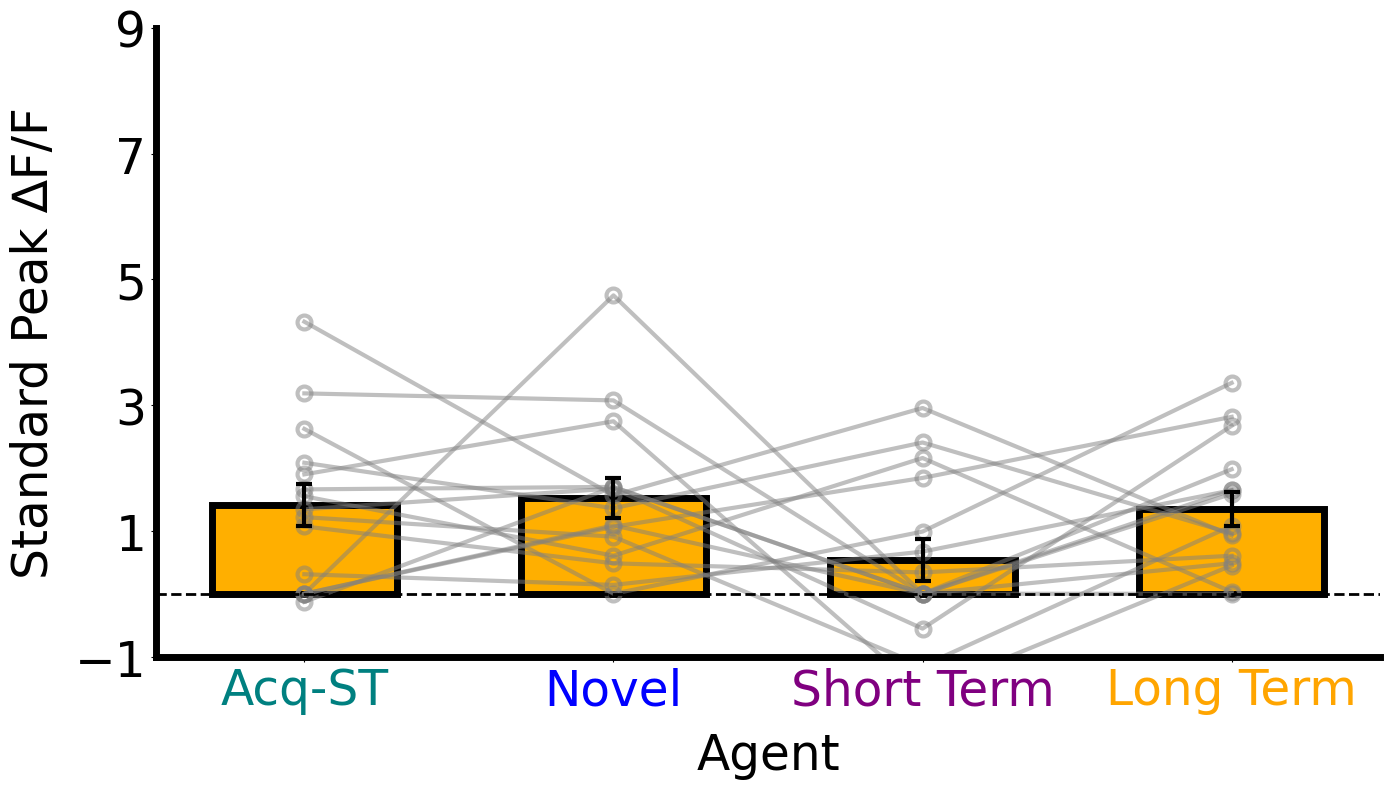


Paired t-test results (first bout vs others):
Short_Term-1 vs Novel-1: p = 0.8100 (ns)
Short_Term-1 vs Short_Term-2: p = 0.0423 (*)
Short_Term-1 vs Long_Term-1: p = 0.9000 (ns)


In [12]:
dopamine(
    precomputed_df=df,
    metric_name="Max Peak",
    ylabel="Standard Peak ∆F/F",
    xlabel="Agent",
    custom_xtick_labels=clean_labels,
    custom_xtick_colors=xtick_colors,
    ylim=(-1, 9),
    yticks_increment=2,
    bar_color=brain_region,
    figsize=(14, 8),
    save=True,
    save_name ="NAc_C1_3",
    title=None
)

In [ ]:
plot_da_metrics_combined_oneplot_integrated(experiment,
                                                metric_name="Max Peak", 
                                                title="NAc C1+2: Standard DA (Peak), 1st Investigation", 
                                                ylabel="Peak standard Z-score ∆F/F", 
                                                xlabel="Agent", 
                                                custom_xtick_labels=["Acq-ST", "Short Term", "Long Term", "Novel"],
                                                custom_xtick_colors=["teal", "blue", "purple", "orange"], 
                                                ylim=(-1, 11), 
                                                bar_color=brain_region, 
                                                yticks_increment=2, 
                                                figsize=(14,8), 
                                                pad_inches=0.1,
                                                save=None,
                                                save_name = "NAc_C12_Standard_Peak"
                                                )

In [ ]:
def plot_da_metrics_combined_oneplot_integrated_updated(experiment, 
                                                metric_name="Mean Z-score", 
                                                title="Combined DA Metrics", 
                                                ylabel="DA Metric", 
                                                xlabel="Bout", 
                                                custom_xtick_labels=None, 
                                                custom_xtick_colors=None, 
                                                ylim=None, 
                                                bar_color="#00B7D7", 
                                                yticks_increment=None, 
                                                figsize=(14,8), 
                                                pad_inches=0.1,
                                                save=False,
                                                save_name=None,
                                                precomputed_df=None):  # New parameter
    """
    Plots DA metrics across specific bouts for all trials in the experiment.
    If p-value < 0.05, it adds a horizontal significance line + asterisk above bars.

    Now supports a precomputed_df parameter to bypass internal data building.
    """

    def perform_t_tests(pivot_df):
        comparisons = {
            "acq_st_vs_short_term": ("Acq-ST", "Short Term"),
            "acq_st_vs_long_term": ("Acq-ST", "Long Term"),
            "acq_st_vs_novel": ("Acq-ST", "Novel")
        }
        results = {}
        for key, (bout1, bout2) in comparisons.items():
            if bout1 in pivot_df.columns and bout2 in pivot_df.columns:
                paired_df = pivot_df[[bout1, bout2]].dropna()
                if len(paired_df) > 1:
                    t_stat, p_value = ttest_rel(paired_df[bout1], paired_df[bout2])
                    results[key] = {"t_stat": t_stat, "p_value": p_value}
        return results

    # --- Step 1: Get Data ---
    if precomputed_df is not None:
        combined_df = precomputed_df.copy()
    else:
        trial_data = []
        for trial_name, trial in experiment.trials.items():
            if hasattr(trial, "behaviors") and not trial.behaviors.empty:
                trial_df = trial.behaviors.copy()
                if metric_name not in trial_df.columns:
                    print(f"Warning: Trial '{trial_name}' missing '{metric_name}'. Skipping.")
                    continue
                df_grouped = trial_df.groupby("Bout", as_index=False)[metric_name].mean()
                df_grouped["Trial"] = trial_name
                trial_data.append(df_grouped)
            else:
                print(f"Warning: Trial '{trial_name}' has no behavior data.")
        if not trial_data:
            print("No data available to plot.")
            return
        combined_df = pd.concat(trial_data, ignore_index=True)

    # --- Step 2: Pivot Data ---
    try:
        pivot_df = combined_df.pivot(index="Trial", columns="Bout", values=metric_name).fillna(0)
    except Exception as e:
        print("Error pivoting data:", e)
        return

    # --- Step 3: Compute stats ---
    overall_stats = combined_df.groupby("Bout")[metric_name].agg(['mean', 'sem']).reset_index()
    t_test_results = perform_t_tests(pivot_df)

    # --- Step 4: Plotting ---
    fig, ax = plt.subplots(figsize=figsize)

    # Bar chart with error bars
    ax.bar(overall_stats["Bout"], overall_stats["mean"], yerr=overall_stats["sem"],
           capsize=6, color=bar_color, edgecolor='black', linewidth=5, width=0.6,
           error_kw=dict(elinewidth=3, capthick=3, zorder=5))
    
    # Individual trial lines
    for trial in pivot_df.index:
        ax.plot(pivot_df.columns, pivot_df.loc[trial], linestyle='-', color='gray', 
                alpha=0.5, linewidth=3, marker='o', markerfacecolor='none', 
                markeredgecolor='gray', markeredgewidth=2, markersize=10)

    # Labels and title
    ax.set_ylabel(ylabel, fontsize=30, labelpad=12)
    ax.set_xlabel(xlabel, fontsize=30, labelpad=12)
    ax.set_title(title, fontsize=28)

    # X-tick labels
    if custom_xtick_labels:
        ax.set_xticks(range(len(custom_xtick_labels)))
        ax.set_xticklabels(custom_xtick_labels, fontsize=28)
        if custom_xtick_colors:
            for tick, color in zip(ax.get_xticklabels(), custom_xtick_colors):
                tick.set_color(color)
    else:
        ax.set_xticklabels(overall_stats["Bout"], fontsize=28)

    ax.tick_params(axis='y', labelsize=30)
    ax.tick_params(axis='x', labelsize=30)
    
    if ylim is None:
        all_values = np.concatenate([pivot_df.values.flatten(), overall_stats["mean"].values])
        ax.set_ylim(0, np.nanmax(all_values) * 1.2)
    else:
        ax.set_ylim(ylim)

    if yticks_increment:
        y_min, y_max = ax.get_ylim()
        ax.set_yticks(np.arange(np.floor(y_min), np.ceil(y_max) + yticks_increment, yticks_increment))

    ax.axhline(y=0, color='black', linestyle='--', linewidth=2)

    # Spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)

    # Significance
    if t_test_results:
        max_y = ax.get_ylim()[1]
        sig_y_offset = max_y * 0.05
        comparisons = {"acq_st_vs_short_term": (0, 1), "acq_st_vs_long_term": (0, 2), "acq_st_vs_novel": (0, 3)}
        line_spacing = sig_y_offset * 2.5
        current_y = np.nanmax(overall_stats["mean"]) + sig_y_offset

        for key, (x1, x2) in comparisons.items():
            if key in t_test_results:
                p_value = t_test_results[key]["p_value"]
                if p_value < 0.05:
                    significance = "**" if p_value < 0.01 else "*"
                    ax.plot([x1, x2], [current_y, current_y], color='black', linewidth=5)
                    ax.text((x1 + x2) / 2, current_y + sig_y_offset / 1.5, significance, fontsize=40, ha='center')
                    current_y += line_spacing

    plt.tight_layout()
    if save:
        if save_name is None:
            raise ValueError("save_name must be provided if save is True.")
        plt.savefig(save_name, transparent=True, bbox_inches='tight', pad_inches=pad_inches)
    plt.show()

In [ ]:
# Your custom bout order
custom_bouts = ["short_term-1", "novel-1", "short_term-2", "long_term-1"]

# Precompute DataFrame with desired bout order
trial_data = []
for trial_name, trial in experiment.trials.items():
    if hasattr(trial, "behaviors") and not trial.behaviors.empty:
        trial_df = trial.behaviors.copy()
        trial_df = trial_df[trial_df["Bout"].isin(custom_bouts)].copy()
        trial_df["Bout"] = pd.Categorical(trial_df["Bout"], categories=custom_bouts, ordered=True)
        df_grouped = trial_df.groupby("Bout", as_index=False)["Mean Z-score"].mean()
        df_grouped["Trial"] = trial_name
        trial_data.append(df_grouped)

precomputed_df = pd.concat(trial_data, ignore_index=True)

# Clean labels for display
xtick_labels = ["Short Term 1", "Novel 1", "Short Term 2", "Long Term 1"]
xtick_colors = ["#0045A6", "#E06928", "#0045A6", "#A839A4"]

# Plot using precomputed data
plot_da_metrics_combined_oneplot_integrated_updated(
    experiment=experiment,
    metric_name="Mean Z-score",
    title="Custom Ordered DA Metrics",
    ylabel="Z-scored ∆F/F",
    xlabel="Bout Type",
    custom_xtick_labels=xtick_labels,
    custom_xtick_colors=xtick_colors,
    ylim=(0, 1),
    bar_color="#00B7D7",
    yticks_increment=0.5,
    figsize=(14, 8),
    save=False,
    precomputed_df=precomputed_df
)

In [ ]:
# Map to clean labels for plotting
xtick_labels = ["Acq-ST 1", "Novel 1", "Acq-ST 2", "Long Term 1"]
xtick_colors = ["#00B7D7", "#E06928", "#00B7D7", "#A839A4"]

# Call the plotting function with sorted bouts
plot_da_metrics_combined_oneplot_integrated(
    experiment=experiment,
    metric_name="Mean Z-score",
    title="Custom Ordered DA Metrics",
    ylabel="DA Z-score",
    xlabel="Bout Type",
    custom_xtick_labels=xtick_labels,
    custom_xtick_colors=xtick_colors,
    ylim=(0, 2.0),
    bar_color="#00B7D7",
    yticks_increment=0.5,
    figsize=(14, 8),
    save=False,
    save_name=None  # Provide name if saving
)

In [ ]:
# Average Bout Duration Across Bouts
hc_plot_behavior_times_across_bouts_gray(
    metadata_df=da_metadata_df,
    y_col="Max Peak",
    behavior="Investigation",
    title="1st Investigation Peak standard z-score DA Across Bouts",
    xlabel="Intruder",
    ylabel="Peak standard z-score DA",
    custom_xtick_labels=["Acq-ST", "Novel", "Short term", "Long term"],
    bout_order=['Short_Term-1', 'Novel-1', 'Short_Term-2', 'Long_Term-1'],
    custom_xtick_colors=["teal", "blue", "purple", "orange"],
    ylim=(-1, 5),
    bar_color=brain_region,
    yticks_increment=2,
    figsize=(12,7),
    pad_inches=0.1,
    save=False,
    save_name=r"Hab_Dishab_Plots\mPFC_DA\mPFC_C1-3_Peak_Across_Bouts.png"
)

In [ ]:
# Average Bout Duration Across Bouts
plot_behavior_times_across_bouts_colored(
    metadata_df=da_metadata_df,
    y_col="Max Peak",
    behavior="Investigation",
    title="1st Investiagtion Peak standard z-score DA Across Bouts",
    xlabel="Intruder",
    ylabel="Peak standard z-score DA",
    custom_xtick_labels=["Acq-ST", "Novel", "Short term", "Long term"],
    bout_order=['Short_Term-1', 'Novel-1', 'Short_Term-2', 'Long_Term-1'],
    custom_xtick_colors=["teal", "blue", "purple", "orange"],
    ylim=(-2, 15),
    bar_color=brain_region,
    yticks_increment=2,
    figsize=(12,7),
    pad_inches=0.1,
    save=False,
    save_name=r"Hab_Dishab_Plots\mPFC_DA\mPFC_C1-3_Peak_Across_Bouts_WIDENTITIES.png"
)

In [ ]:
experiment.reset_all_behaviors()
experiment.group_extract_manual_annotations(bout_definitions=bout_definitions, first_only = False)

# total_avg_bout_duration = metadata_df["Average Bout Duration"].mean()
# print(f"Total Average Bout Duration: {total_avg_bout_duration:.4f}")
# Proceed with DA metric computation after all files are processed
experiment.compute_all_da_metrics(use_max_length=False,
                                  max_bout_duration=4, #otal_avg_bout_duration
                                  use_adaptive=False, 
                                  allow_bout_extension=False,
                                  mode='standard')

In [ ]:
exp_da_dict = get_trial_dataframes(experiment)

In [ ]:
# Suppose exp_da_dict = {"nn8": df_nn8, "nn3": df_nn3, ...}

# Plot the first 3 investigations for bouts s1-1 and s1-2:
df_final = plot_peak_for_subsequent_investigations_custom(
    exp_da_dict,
    selected_bouts=['Short_Term-1', 'Novel-1', 'Short_Term-2', 'Long_Term-1'],
    n_subsequent_investigations=5,
    peak_col="Max Peak",
    metric_type='decay', 
    ylim=(0, 5)
)


In [ ]:
df_final